# **[DNC] ASSIGNMENT 20 - CLASSIFICAÇÃO E RECOMENDAÇÃO**

### **CONTEXTO:**

O CEO da Amazon contratou um time de cientistas de dados
para trabalhar em diferentes vertentes da empresa, e você
ficou encarregado de fazer um sistema de recomendação para
os clientes Amazon.

Para isso, te deram acesso à uma base de
dados não muito estruturada em **Json**: um arquivo de
metadata com informações dos produtos e outro com as
avaliações.

### **PROJETO:**
O CEO deseja que seu algoritmo de recomendação seja exclusivamente em cima de avaliações verificadas (`verified=True`).

Contudo, há uma base sem classificação a qual o CEO faz questão de que seja
adicionada no sistema de recomendação (valores com missing value na coluna `verified`). Para isso, você precisará **classificar se estas avaliações são verificadas ou não**, e no caso positivo, adicioná-los no sistema de recomendação.

Adicionalmente, o CEO também deseja saber de possíveis associações e/ou correlações nesta base de dados que você vai trabalhar.

Desta forma, eis o que você deve fazer neste projeto:

*   Carregar, limpar e fazer análises exploratórias no banco de dados fornecido;
*   Classificar a base sem informação para incluir as observações
das avaliações verificadas no sistema de recomendação;
*   Desenvolver e entregar um sistema de recomendação, com
exemplos de aplicação.

# 1 - Importando as Bibliotecas

In [109]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Setando alguns parâmetros de leitura do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Setando alguns parámetros de exibição dos plots
sns.set_theme(
    context='talk', style='ticks', font_scale=0.8,
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.labelpad': 15,
    }
)

# 2 - Carregando os dados

### 2.1 Download dos datasets do Google Drive

In [3]:
!gdown --id '1RSFSKQx5dep63ds5ecD4Zgd-JBhtM-CZ'
!gdown --id '18sYnyi1w-k7IWiY4dgpYZNRXwxO2oWYO'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1RSFSKQx5dep63ds5ecD4Zgd-JBhtM-CZ
To: /content/meta_Video_Games.json
100% 243M/243M [00:02<00:00, 120MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18sYnyi1w-k7IWiY4dgpYZNRXwxO2oWYO
To: /content/Video_Games_sample.json
100% 278M/278M [00:01<00:00, 154MB/s]


### 2.2 Leitura dos datasets

In [4]:
# Carregando os datasets
df_reviews = pd.read_json('/content/Video_Games_sample.json', lines=True)
df_metadados = pd.read_json('/content/meta_Video_Games.json', lines=True)

In [5]:
df_reviews.shape

(453562, 12)

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453562 entries, 0 to 453561
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         453562 non-null  int64  
 1   reviewTime      453562 non-null  object 
 2   reviewerID      453562 non-null  object 
 3   asin            453562 non-null  object 
 4   style           318160 non-null  object 
 5   reviewerName    453511 non-null  object 
 6   reviewText      453217 non-null  object 
 7   summary         453396 non-null  object 
 8   unixReviewTime  453562 non-null  int64  
 9   verified        384546 non-null  float64
 10  vote            57123 non-null   object 
 11  image           4651 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 41.5+ MB


In [7]:
df_reviews.head(2)

,overall,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,verified,vote,image
0,1,"01 2, 2018",A16FEXIKAPT24U,B00000JRSB,{'Format:': ' Video Game'},Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,NaN,NaN
1,5,"01 2, 2018",A3ISBEPYLY8IMO,B00000JRSB,{'Format:': ' Video Game'},Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0,NaN,NaN


In [8]:
df_metadados.shape

(84819, 19)

In [9]:
df_metadados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [10]:
df_metadados.head(2)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


# 3 - Data Cleaning

### 3.1 - Dataset com os dados de Reviews

In [11]:
df_reviews.head(1)

,overall,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,verified,vote,image
0,1,"01 2, 2018",A16FEXIKAPT24U,B00000JRSB,{'Format:': ' Video Game'},Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,NaN,NaN


In [12]:
# Formatando reviewTime
df_reviews['reviewTime'] = pd.to_datetime(df_reviews['reviewTime'], format='%m %d, %Y')

In [13]:
# Formatando style
df_reviews['style'] = pd.json_normalize(df_reviews['style'])['Format:']

Verificação do percentual de nulos

In [14]:
(df_reviews.isna().sum() / df_reviews.shape[0]).map("{:.2%}".format)

overall            0.00%
reviewTime         0.00%
reviewerID         0.00%
asin               0.00%
style             68.25%
reviewerName       0.01%
reviewText         0.08%
summary            0.04%
unixReviewTime     0.00%
verified          15.22%
vote              87.41%
image             98.97%
dtype: object

O campo **style** possui uma grande quantidade de valores nulos, porém, primeiro vou fazer uma análise para ver se ela possui informações que úteis antes de descartá-la por completo.

In [15]:
df_reviews['style'].unique()

array([' Video Game', nan, ' Console', ' Electronics', ' Card',
       ' Online Game Code', ' Misc.', ' DVD-ROM', ' Software Download',
       ' Computer Game', ' Personal Computers'], dtype=object)

In [16]:
(df_reviews['style'].value_counts(dropna=False) / df_reviews.shape[0]).map("{:.2%}".format)

NaN                    68.25%
 Video Game            27.48%
 Computer Game          1.68%
 DVD-ROM                0.72%
 Online Game Code       0.56%
 Software Download      0.49%
 Personal Computers     0.38%
 Card                   0.35%
 Console                0.05%
 Electronics            0.04%
 Misc.                  0.00%
Name: style, dtype: object

Farei agora uma análise do campo **vote**, outro campo com grande quantidade de nulos.

In [17]:
(df_reviews['vote'].value_counts(dropna=False) / df_reviews.shape[0]).map("{:.2%}".format).head(10)

NaN    87.41%
2       3.89%
3       1.98%
4       1.21%
5       0.87%
6       0.63%
7       0.50%
8       0.43%
9       0.36%
10      0.31%
Name: vote, dtype: object

Na coluna **style**, fora os valores nulos, quase sua totalidade tem o valor 'Video Game'.

Na coluna **vote** existe uma distribuição um pouco melhor, porém a quantidade de nulos é muito alta.

Sendo assim, irei excluir essas coluna por entender que não irão agregar na análise.

E também irei excluir a coluna **image** que, além de conter muitos nulos, não iremos trabalhar com imagens nesse projeto.


In [18]:
df_reviews.drop(columns=['vote', 'image', 'style'], inplace=True)

Farei a remoção de linhas duplicadas

In [19]:
print(f'{df_reviews.duplicated().sum()} linhas duplicadas')

linhas_before_drop = df_reviews.shape[0]

df_reviews.drop_duplicates(inplace=True)

print("Foram removidas {} linhas".format(linhas_before_drop - df_reviews.shape[0]))

17525 linhas duplicadas
Foram removidas 17525 linhas


Agora o dataset de reviews ficou da seguinte forma:

In [20]:
df_reviews.shape

(436037, 9)

In [21]:
df_reviews.head(3)

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,verified
0,1,2018-01-02,A16FEXIKAPT24U,B00000JRSB,Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN
1,5,2018-01-02,A3ISBEPYLY8IMO,B00000JRSB,Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0
2,5,2017-12-21,A1RIUB1PZWLOVZ,B00000JRSB,Amazon Customer,I had a hard time finding this game locally or...,I am very pleased with this purchase,1513814400,1.0


### 3.2 - Dataset com os Metadados

In [22]:
df_metadados.head(1)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


Em uma análise prévia, identifiquei que os metadados contém informações de vários itens.

Portanto, irei filtra apenas os **asin** dos itens que tenham review (que estão no df_reviews), pois não precisarei dos demais itens para esta análise.

In [23]:
itens_reviewds = list(df_reviews['asin'].unique())

In [24]:
df_metadados = df_metadados[df_metadados['asin'].isin(itens_reviewds)]

Percentual de Nulos

In [25]:
(df_metadados.isna().sum() / df_metadados.shape[0]).map("{:.2%}".format)

category           0.00%
tech1              0.00%
description        0.00%
fit                0.00%
title              0.00%
also_buy           0.00%
tech2              0.00%
brand              0.00%
feature            0.00%
rank               0.00%
also_view          0.00%
main_cat           0.00%
similar_item       0.00%
date               0.00%
price              0.00%
asin               0.00%
imageURL           0.00%
imageURLHighRes    0.00%
details            0.00%
dtype: object

Percentual de Nulos está zero, mas percebo que existem varios valores **[ ]** e valores em branco.

Vou fazer a **substituição** de **[ ]** e dos **valores em branco** por **np.nan** para depois refazer a contagem dos nulos.

In [26]:
def replace_vazios(x):
  if x == []:
    return np.nan
  else:
    return x


for c in df_metadados.columns:
  df_metadados[c] = df_metadados.apply(lambda x : replace_vazios(x[c]), axis=1)

df_metadados.replace('', np.nan, inplace=True)

In [27]:
(df_metadados.isna().sum() / df_metadados.shape[0]).map("{:.2%}".format)

category             0.00%
tech1               88.09%
description          7.58%
fit                100.00%
title                0.00%
also_buy            15.52%
tech2               96.39%
brand                0.00%
feature              4.69%
rank                 0.72%
also_view            2.89%
main_cat             0.00%
similar_item        99.28%
date                76.90%
price               12.64%
asin                 0.00%
imageURL             6.14%
imageURLHighRes      6.14%
details              0.00%
dtype: object

Nesse dataset irei adotar o critério de descartar aquelas colunas que tenham mais de 70% de valores nulos.

Sendo assim, irei excluir as colunas: **tech1, fit, tech2, similar_item, date**

E vou excluir também as colunas: **imageURL e imageURLHighRes** pois não vamos trabalhar com imagens nesse projeto.


In [28]:
df_metadados.drop(columns=['tech1', 'fit', 'tech2', 'similar_item', 'date', 'imageURL', 'imageURLHighRes'], inplace=True)

Agora vou analisar os campos que restaram.

In [29]:
df_metadados.columns

Index(['category', 'description', 'title', 'also_buy', 'brand', 'feature',
       'rank', 'also_view', 'main_cat', 'price', 'asin', 'details'],
      dtype='object')

Coluna ***category***

In [30]:
df_metadados['category']

399      [Video Games, Retro Gaming &amp; Microconsoles...
6758     [Video Games, Retro Gaming &amp; Microconsoles...
6779     [Video Games, Retro Gaming & Microconsoles, Pl...
6975     [Video Games, Retro Gaming & Microconsoles, Ga...
7244     [Video Games, Retro Gaming &amp; Microconsoles...
                               ...                        
84373    [Video Games, PlayStation 4, Digital Games & D...
84386    [Video Games, PlayStation 4, Games, </span></s...
84506    [Video Games, PlayStation 4, Accessories, Batt...
84561            [Video Games, Wii, </span></span></span>]
84610             [Video Games, PC, Accessories, Headsets]
Name: category, Length: 277, dtype: object

Category aparenta ter um padrão, é uma lista que contém:

1.   categoria principal
1.   plataforma (console, pc e etc.) 
1.   categoria mais específica 

A categoria principal já tem um campo específico que é o **main_cat**.

Portanto, desse campo vou tentar extrair dois valores: a **plataforma** e a **categoria especifica**.



In [31]:
def category_extract(c, index):
  if type(c) == list:
    try:
      return c[index]
    except:
      return np.nan


df_metadados['plataform'] = df_metadados['category'].apply(lambda x : category_extract(x, 1))
df_metadados['category'] = df_metadados['category'].apply(lambda x : category_extract(x, 2))

In [32]:
df_metadados['plataform'] = df_metadados['plataform'].replace('Retro Gaming &amp; Microconsoles', 'Retro Gaming').replace('Retro Gaming & Microconsoles', 'Retro Gaming')

In [33]:
df_metadados['plataform'].value_counts()

PC                    64
PlayStation 4         43
PlayStation 3         28
Xbox 360              28
Kids & Family         27
Retro Gaming          24
Xbox One              24
Wii                   15
Nintendo 3DS & 2DS     9
Nintendo DS            5
Accessories            3
Wii U                  3
PlayStation Vita       2
Mac                    1
Digital Games          1
Name: plataform, dtype: int64

In [34]:
df_metadados['category'].value_counts()

Accessories                          112
Games                                 66
</span></span></span>                 25
PlayStation 2                         11
Wii                                    9
Consoles                               9
Nintendo 3DS                           9
GameCube                               4
Xbox                                   4
Wii U                                  3
PlayStation 4                          3
Xbox 360                               2
Interactive Gaming Figures             2
PlayStation                            2
Currency & Subscription Cards          2
Game Boy Advance                       2
Digital Games & DLC                    2
Currency &amp; Subscription Cards      1
PlayStation 3                          1
PC                                     1
NVIDIA SHIELD                          1
Name: category, dtype: int64

Irei substituir esse valor `</span></span></span>` por 'Outros' para fins de análise.

In [35]:
df_metadados['category'] = df_metadados['category'].replace('</span></span></span>', 'Outros')

Coluna ***description***         

In [36]:
df_metadados['description']

399      [Long recognized as role-playing games par exc...
6758     [The explosions will light up your living room...
6779                                [Grand Theft Auto III]
6975     [Can Mario beat Donkey Kong? Is Pikachu toughe...
7244     [Final Fantasy X finally enters a fully polygo...
                               ...                        
84373    [<div>Winner of more than 200 Game of the Year...
84386    [<div>, From Santa Monica Studio and creative ...
84506                                                  NaN
84561    [The Pokemon GO Plus accessory can be used wit...
84610    [<span class="a-text-bold">BENGOO G9000 Headse...
Name: description, Length: 277, dtype: object

In [37]:
df_metadados['description'][84610]

['<span class="a-text-bold">BENGOO G9000 Headset</span> is a primary kind of gaming headset for <span class="a-text-bold"><span class="a-text-italic"><u>PlayStation 4, Xbox one PC, Laptop and Mac</u></span></span> Games which brings you vivid sound field, sound clarity and sound shock feeling, capable of various games like Halo 5 Guardians, Metal Gear Solid, Call of Duty, Star Wars Battlefront, EA Sports UFC, Overwatch, World of Warcraft Legion, etc. Its super soft Over-ear pads is more comfortable for long time wear, and it is a great headphone especially perfect <span class="a-text-bold">for gamer</span>!<br> &nbsp;<br> <span class="a-text-bold"><span class="a-text-italic"><u>Why you choose BENGOO gaming headset?</u></span></span><br> <span class="a-text-italic">1.<u>Environmental friendly material</u></span>Earmuffs used with the new second-generation skin-friendly material, reduce heat sweat, more suitable for long wear.<br> <span class="a-text-italic">2.<u>HIGH COMPATIBILITY</u></

O campo ***description*** é uma descrição do item.

Ele está dentro de uma lista, e contém algumas tags html no texto.

Vou fazer um tratamento deixando apenas o texto, pode ser que fiquem algumas tags html, que se identificadas futuramente eu faço a remoção.

In [38]:
# Retirar os valores de dentro dos colchetes
df_metadados['description'] = df_metadados['description'].apply(lambda x: x[0] if type(x) == list else x)

# Removendo tags html da descrição
df_metadados['description'] = df_metadados['description'].apply(lambda x: x.replace('<div>', '') \
                                                                            .replace('<br>', '') \
                                                                            .replace('</br>', '') \
                                                                            .replace('<b>', '') \
                                                                            .replace('</b>', '') \
                                                                            .replace('<span class="a-text-bold">', '') \
                                                                            .replace('<span class="a-text-italic">', '')
                                                                            .replace('</span>', '') \
                                                                            .replace('<u>', '') \
                                                                            .replace('</u>', '') \
                                                                            .replace('&nbsp;', '') \
                                                                            if type(x) != float else x)

df_metadados['description']

399      Long recognized as role-playing games par exce...
6758     The explosions will light up your living room....
6779                                  Grand Theft Auto III
6975     Can Mario beat Donkey Kong? Is Pikachu tougher...
7244     Final Fantasy X finally enters a fully polygon...
                               ...                        
84373    Winner of more than 200 Game of the Year Award...
84386                                                     
84506                                                  NaN
84561    The Pokemon GO Plus accessory can be used with...
84610    BENGOO G9000 Headset is a primary kind of gami...
Name: description, Length: 277, dtype: object

Coluna ***title***

In [39]:
df_metadados['title']

399                                      Final Fantasy VII
6758                                           Halo - Xbox
6779                                  Grand Theft Auto III
6975                                Super Smash Bros Melee
7244                                       Final Fantasy X
                               ...                        
84373    The Elder Scrolls V: Skyrim Special Edition - ...
84386                    God of War 4 - PS4 [Digital Code]
84506    PS4 Controller Charger, Y Team Playstation 4 /...
84561                             Nintendo Pokemon Go Plus
84610    BENGOO G9000 Stereo Gaming Headset for PS4, PC...
Name: title, Length: 277, dtype: object

A principio title parece não precisar de nenhum tratamento.


Coluna ***also_buy*** e ***also_view***

In [40]:
df_metadados['also_buy']

399      [B0000296O5, B00004Y57G, B00002R28C, B0045L3SN...
6758     [B00008J7NZ, B00006IR20, B000FRU0NU, B00005RHQ...
6779     [B0000696CZ, B0001VGFK2, B01L1P49OA, B00006BXB...
6975     [B00009WAUD, B00006IJJI, B00005QEFF, B01LWA474...
7244     [B00008URUA, B000F5IH2I, B000066TS5, B0009A4EV...
                               ...                        
84373    [B004RMK4BC, B004RMK4P8, B06XCTDL52, B00GAC1D2...
84386    [B01H0TJM70, B07G9WK8GS, B072LXFN8X, B07DLTC77...
84506    [B01LWVX2RG, B07GQ61M42, B0799976M1, B07FQ74V4...
84561    [B07C7K7JGW, B07HNC7JB9, B07C75329M, B07C7L9D9...
84610                                                  NaN
Name: also_buy, Length: 277, dtype: object

In [41]:
df_metadados['also_view']

399      [B00004Y57G, B00004TC6E, B00ZS80PC2, B0000296O...
6758     [B0050SYY5E, B000FRU0NU, B00008J7NZ, B00006IR2...
6779     [B0000696CZ, B0001VGFK2, B00006BXBV, B000KCX9M...
6975     [B000094G2O, B00008KTX5, B00009WAUD, B0009XBYZ...
7244     [B000066TS5, B000F5IH2I, B00008URUA, B00QU47SJ...
                               ...                        
84373    [B01J23D1W4, B01H0TJM70, B07L9NVPTY, B07BZZX97...
84386    [B01H0TJM70, B01GW3PMGK, B072LXFN8X, B07G9WK8G...
84506                                                  NaN
84561    [B071K63M65, B06Y5BTX8L, B071R3P45V, B07C1MCH3...
84610    [B076DWKD5B, B01MA5XZSG, B078RJGK35, B012DFI02...
Name: also_view, Length: 277, dtype: object

Colunas que contém os IDs (asin) de produtos Comprado/Visto juntos.

Não irei manter essas informações no dataset final, já que iremos fazer um sistema de recomendação próprio.

Coluna ***brand***

In [42]:
df_metadados['brand']

399                    SquareSoft
6758      by\n    \n    Microsoft
6779                         Sony
6975       by\n    \n    Nintendo
7244     by\n    \n    SquareSoft
                   ...           
84373      by\n    \n    Bethesda
84386          by\n    \n    SCEA
84506                      Y Team
84561      by\n    \n    Nintendo
84610                      BENGOO
Name: brand, Length: 277, dtype: object

Marca do item, vou realizar um tratamento para deixar apenas o nome da marca.

In [43]:
import re

# Removendo os caracteres especiais
df_metadados['brand'] = df_metadados['brand'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]"," ", x))

# Removendo o "by" e os espaços em branco
df_metadados['brand'] = df_metadados['brand'].apply(lambda x: x.replace("by","").strip())

df_metadados['brand']

399      SquareSoft
6758      Microsoft
6779           Sony
6975       Nintendo
7244     SquareSoft
            ...    
84373      Bethesda
84386          SCEA
84506        Y Team
84561      Nintendo
84610        BENGOO
Name: brand, Length: 277, dtype: object

In [44]:
df_metadados['brand'].value_counts()

Nintendo      38
Sony          31
Microsoft     27
Ubisoft       18
Logitech      15
              ..
UtechSmart     1
AULA           1
Zelotes        1
Datel          1
BENGOO         1
Name: brand, Length: 71, dtype: int64

Vou fazer um agrupamento das marcas com poucos itens em "Outras"

In [45]:
top_10_marcas = list((df_metadados['brand'].value_counts() < 5).index)[:10]
df_metadados['brand'] = df_metadados['brand'].apply(lambda x : x if x in top_10_marcas else 'Outras')

df_metadados['brand'].value_counts()

Outras             100
Nintendo            38
Sony                31
Microsoft           27
Ubisoft             18
Logitech            15
Electronic Arts     15
Activision          11
Razer               10
SquareSoft           6
Turtle Beach         6
Name: brand, dtype: int64

Coluna ***feature***

In [46]:
df_metadados['feature']

399      [1 Player, RPG, 3 Disc Set, Excellent graphics...
6758     [Control a character during massive firefights...
6779                   [Sony Playstion 2 Grand Theft auto]
6975     [Number of Players: Offline: 1-4 Players, Numb...
7244     [Learn to summon aeons-old spirits of power to...
                               ...                        
84373    [Winner of more than 200 Game of the Year Awar...
84386    [A New Beginning - His vengeance against the g...
84506    [Sleek and Compact--This dual charger provides...
84561    [The Pokmon GO Plus is a small device that let...
84610    [MULTI-PLATFORM COMPATIBLESupport PlayStation ...
Name: feature, Length: 277, dtype: object

Descrição do item, vou remover o valor da lista, deixando apenas o texto no campo.

In [47]:
# Retirar os valores de dentro dos colchetes
df_metadados['feature'] = df_metadados['feature'].apply(lambda x: x[0] if type(x) == list else x)

In [48]:
df_metadados['feature']

399                                               1 Player
6758     Control a character during massive firefights ...
6779                     Sony Playstion 2 Grand Theft auto
6975               Number of Players: Offline: 1-4 Players
7244     Learn to summon aeons-old spirits of power to ...
                               ...                        
84373    Winner of more than 200 Game of the Year Award...
84386    A New Beginning - His vengeance against the go...
84506    Sleek and Compact--This dual charger provides ...
84561    The Pokmon GO Plus is a small device that lets...
84610    MULTI-PLATFORM COMPATIBLESupport PlayStation 4...
Name: feature, Length: 277, dtype: object

Coluna ***rank***

In [49]:
df_metadados['rank']

399      [>#5,076 in Video Games (See Top 100 in Video ...
6758     [>#10,894 in Video Games (See Top 100 in Video...
6779     [>#5,281 in Video Games (See Top 100 in Video ...
6975     [>#1,590 in Video Games (See Top 100 in Video ...
7244     [>#2,933 in Video Games (See Top 100 in Video ...
                               ...                        
84373    [>#21,926 in Video Games (See Top 100 in Video...
84386    [>#10,661 in Video Games (See Top 100 in Video...
84506    [>#57 in Electronics (See Top 100 in Electroni...
84561    [>#388 in Video Games (See Top 100 in Video Ga...
84610    [>#1 in Video Games > PlayStation 4 > Accessor...
Name: rank, Length: 277, dtype: object

Não vou utilizar esse campo, a informação que ele contém é muito confusa.
E acredito que foge do escopo do projeto.

Coluna ***main_cat***

In [50]:
df_metadados['main_cat']

399          Video Games
6758         Video Games
6779         Video Games
6975         Video Games
7244         Video Games
              ...       
84373        Video Games
84386        Video Games
84506    All Electronics
84561        Video Games
84610          Computers
Name: main_cat, Length: 277, dtype: object

Categoria principal do item, conforme citado no tratamento da coluna category.

Não será necessário nenhum tratamento extra.

In [51]:
df_metadados['main_cat'].unique()

array(['Video Games', 'All Electronics', 'Computers', 'Sports & Outdoors',
       'Amazon Home'], dtype=object)

Coluna ***price***

In [52]:
df_metadados['price']

399                                                $164.91
6758     \n\t\t                                        ...
6779                                                 $6.66
6975                                                   NaN
7244     \n\t\t                                        ...
                               ...                        
84373    \n\t\t                                        ...
84386    \n\t\t                                        ...
84506                                                $1.86
84561    \n\t\t                                        ...
84610                                               $24.99
Name: price, Length: 277, dtype: object

Não utilizarei a coluna preço.

Coluna ***details***

In [53]:
df_metadados['details']

399      {}
6758     {}
6779     {}
6975     {}
7244     {}
         ..
84373    {}
84386    {}
84506    {}
84561    {}
84610    {}
Name: details, Length: 277, dtype: object

Aparentava ser uma coluna totalmente preenchida, porém vemos que não tem informação alguma.

Após as análises, conforme explicado, vou excluir as colunas: **also_buy, rank, also_view , price e details**

In [54]:
df_metadados.drop(columns=['also_buy', 'rank', 'also_view', 'price', 'details'], inplace=True)

No final o dataset de metadados ficou da seguinte forma: 

In [55]:
df_metadados.shape

(277, 8)

In [56]:
df_metadados.head(3)

,category,description,title,brand,feature,main_cat,asin,plataform
399,PlayStation,Long recognized as role-playing games par exce...,Final Fantasy VII,SquareSoft,1 Player,Video Games,B00000JRSB,Retro Gaming
6758,Xbox,The explosions will light up your living room....,Halo - Xbox,Microsoft,Control a character during massive firefights ...,Video Games,B00005NZ1G,Retro Gaming
6779,PlayStation 2,Grand Theft Auto III,Grand Theft Auto III,Sony,Sony Playstion 2 Grand Theft auto,Video Games,B00005O0I2,Retro Gaming


### 3.3 Junção dos datasets pelo asin (Código do Item)

In [57]:
df = pd.merge(df_reviews, df_metadados, how='left', on='asin')

In [58]:
df.shape

(450424, 16)

In [59]:
df.head(3)

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,verified,category,description,title,brand,feature,main_cat,plataform
0,1,2018-01-02,A16FEXIKAPT24U,B00000JRSB,Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,PlayStation,Long recognized as role-playing games par exce...,Final Fantasy VII,SquareSoft,1 Player,Video Games,Retro Gaming
1,1,2018-01-02,A16FEXIKAPT24U,B00000JRSB,Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,PlayStation,Long recognized as role-playing games par exce...,Final Fantasy VII,SquareSoft,1 Player,Video Games,Retro Gaming
2,5,2018-01-02,A3ISBEPYLY8IMO,B00000JRSB,Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.0,PlayStation,Long recognized as role-playing games par exce...,Final Fantasy VII,SquareSoft,1 Player,Video Games,Retro Gaming


Vou reorganizar a ordem das colunas e também renomear algumas delas para deixar um padrão melhor no dataset

In [60]:
df.columns

Index(['overall', 'reviewTime', 'reviewerID', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'verified', 'category',
       'description', 'title', 'brand', 'feature', 'main_cat', 'plataform'],
      dtype='object')

In [61]:
df = df.reindex(columns=['reviewTime', 'reviewerID', 'reviewerName', 'asin',
                         'title', 'brand', 'main_cat', 'plataform', 'category',
                         'description', 'summary', 'feature', 'unixReviewTime',
                         'reviewText', 'verified', 'overall']) \
                         .rename(columns = {'main_cat':'main_category',
                                            'category':'specific_category'})
                         
df.head(3)

,reviewTime,reviewerID,reviewerName,asin,title,brand,main_category,plataform,specific_category,description,summary,feature,unixReviewTime,reviewText,verified,overall
0,2018-01-02,A16FEXIKAPT24U,Nicholas Sabin,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Game disc 1 was cracked,1 Player,1514851200,Game disc was cracked thats pretty lame,NaN,1
1,2018-01-02,A16FEXIKAPT24U,Nicholas Sabin,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Game disc 1 was cracked,1 Player,1514851200,Game disc was cracked thats pretty lame,NaN,1
2,2018-01-02,A3ISBEPYLY8IMO,Jimmy,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Received this in perfect condition. Great rese...,1 Player,1514851200,Received this in perfect condition. Great rese...,1.0,5


Verificar o percentual de Nulos do dataset final.

In [62]:
(df.isna().sum() / df.shape[0]).map("{:.2%}".format)

reviewTime            0.00%
reviewerID            0.00%
reviewerName          0.01%
asin                  0.00%
title                 0.00%
brand                 0.00%
main_category         0.00%
plataform             0.00%
specific_category     2.92%
description           8.70%
summary               0.04%
feature               5.38%
unixReviewTime        0.00%
reviewText            0.08%
verified             15.69%
overall               0.00%
dtype: object

O percentual de nulos é baixo, e sendo assim, vou optar por remover as linhas que tenham valores nulos já que o impacto será pequeno.

Só não irei excluir os nulos da da variável **verified** pois faremos um algoritmo de classificação para preencher os dados faltantes desta coluna.

In [63]:
df_cleaned = df.dropna(subset=['reviewerName', 'reviewText', 'summary', 'specific_category', 'description', 'feature'])

In [64]:
(df_cleaned.isna().sum() / df_cleaned.shape[0]).map("{:.2%}".format)

reviewTime            0.00%
reviewerID            0.00%
reviewerName          0.00%
asin                  0.00%
title                 0.00%
brand                 0.00%
main_category         0.00%
plataform             0.00%
specific_category     0.00%
description           0.00%
summary               0.00%
feature               0.00%
unixReviewTime        0.00%
reviewText            0.00%
verified             15.73%
overall               0.00%
dtype: object

Agora vou realizar uma análise no dataset final e depois selecionar as features para o modelo de classificação que usarei para classificar os valores faltantes do campo ***verified***.

# 4 - Análise Exploratória

In [65]:
df_cleaned.head(2)

,reviewTime,reviewerID,reviewerName,asin,title,brand,main_category,plataform,specific_category,description,summary,feature,unixReviewTime,reviewText,verified,overall
0,2018-01-02,A16FEXIKAPT24U,Nicholas Sabin,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Game disc 1 was cracked,1 Player,1514851200,Game disc was cracked thats pretty lame,NaN,1
1,2018-01-02,A16FEXIKAPT24U,Nicholas Sabin,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Game disc 1 was cracked,1 Player,1514851200,Game disc was cracked thats pretty lame,NaN,1


A distribuição das verificações das avaliações

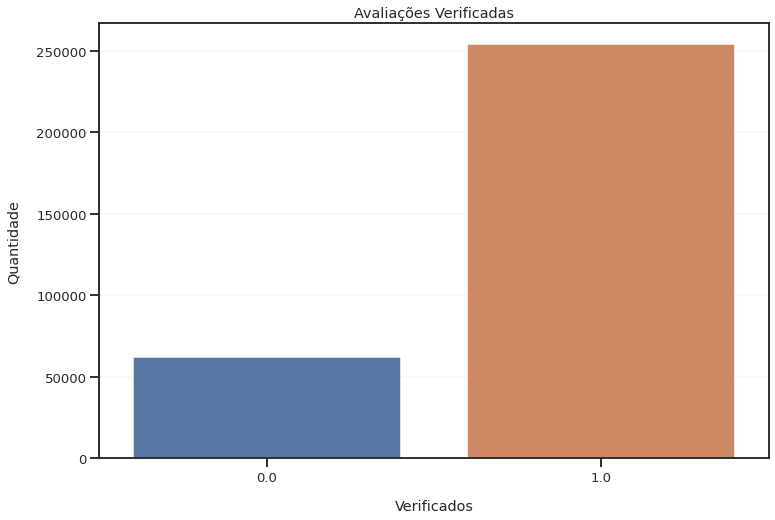

In [106]:
verifieds = df_cleaned['verified'].value_counts().reset_index()

plt.title('Avaliações Verificadas')
sns.barplot(x='index', y='verified', data=verifieds)
plt.xlabel('Verificados')
plt.ylabel('Quantidade')
plt.show()

A distribuição das notas dos reviews mostra que a grande maioria são notas máximas (5 estrelas)

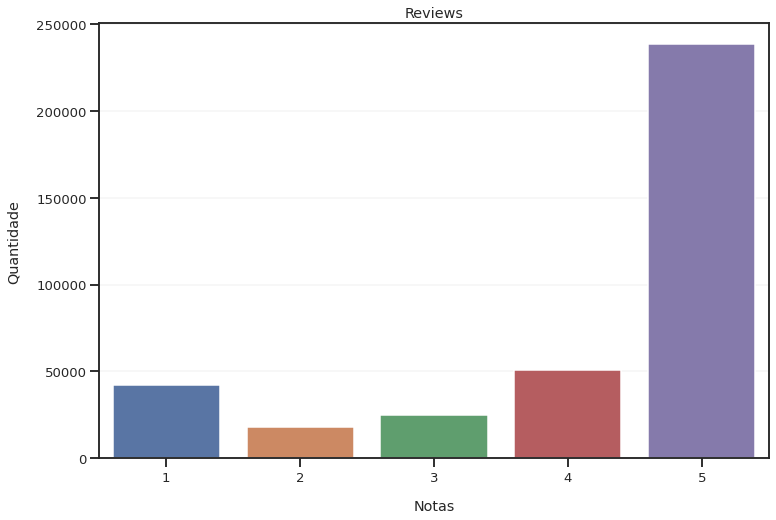

In [66]:
reviews = df_cleaned['overall'].value_counts().reset_index()

plt.title('Reviews')
sns.barplot(x='index', y='overall', data=reviews)
plt.xlabel('Notas')
plt.ylabel('Quantidade')
plt.show()

Os 10 usuários que mais realizaram avaliações.

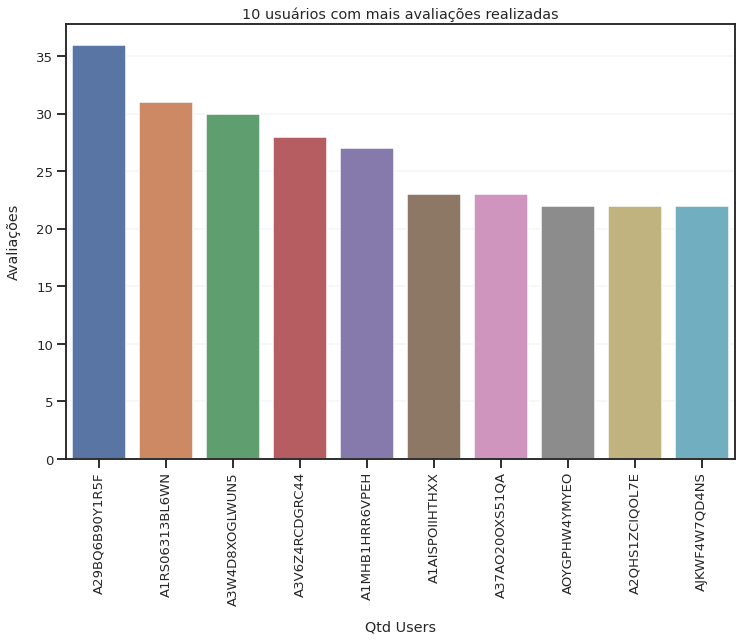

In [67]:
top_10_users = df_cleaned['reviewerID'].value_counts()[:10].reset_index()

plt.title('10 usuários com mais avaliações realizadas')
sns.barplot(x='index', y='reviewerID', data=top_10_users)
plt.xticks(rotation = 90)
plt.xlabel('Qtd Users')
plt.ylabel('Avaliações')
plt.show()

 Os 10 itens com o maior número de avaliações (não necessariamente positivas)

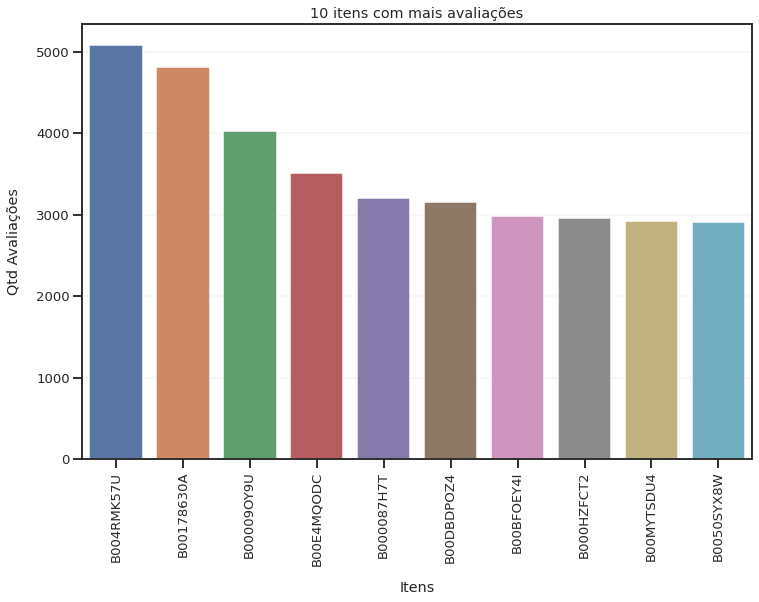

In [68]:
top_10_items = df_cleaned['asin'].value_counts()[:10].reset_index()

plt.title('10 itens com mais avaliações')
sns.barplot(x='index', y='asin', data=top_10_items)
plt.xticks(rotation = 90)
plt.xlabel('Itens')
plt.ylabel('Qtd Avaliações')
plt.show()

A grande maioria dos itens são da categoria Video Game e bem abaixo temos PC em segundo lugar

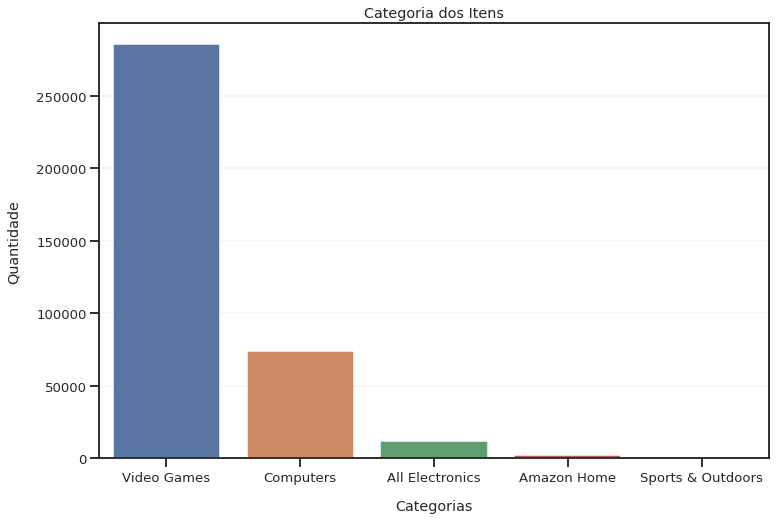

In [69]:
categories = df_cleaned['main_category'].value_counts().reset_index()

plt.title('Categoria dos Itens')
sns.barplot(x='index', y='main_category', data=categories)
plt.xlabel('Categorias')
plt.ylabel('Quantidade')
plt.show()

A plataforma com maior número absoluto é PC.

Mas como visto anteriormente, a categoria de maior peso são os Video-Games.

Como tem vários modelos de video-games, eles juntos estão em maior número absolut.

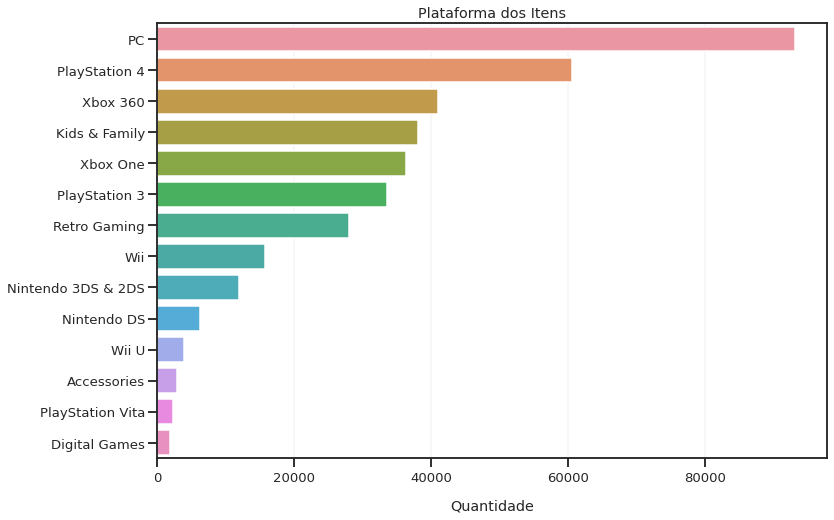

In [70]:
plataforms = df_cleaned['plataform'].value_counts().reset_index()

plt.title('Plataforma dos Itens')
sns.barplot(x='plataform', y='index', data=plataforms)
plt.xlabel('Quantidade')
plt.ylabel('')
plt.show()

A maioria são Acessórios, seguido de Games e Outros

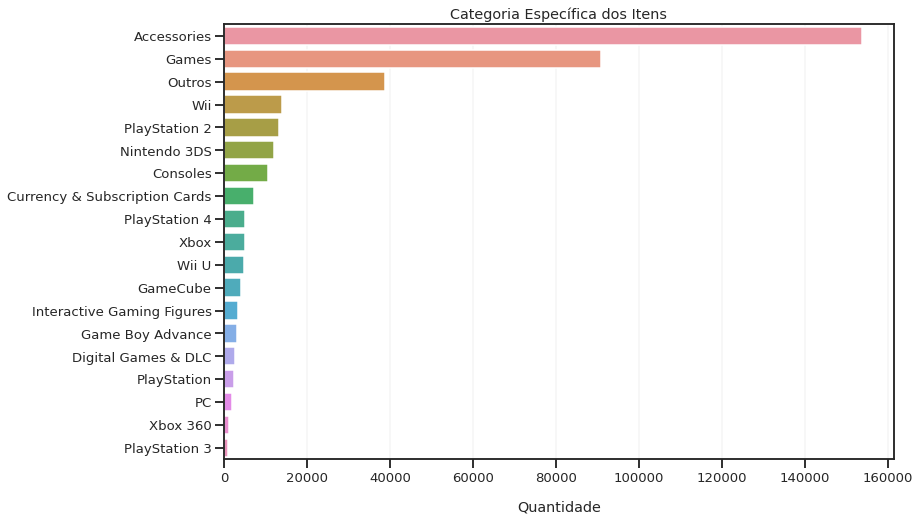

In [71]:
consoles = df_cleaned['specific_category'].value_counts().reset_index()

plt.title('Categoria Específica dos Itens')
sns.barplot(x='specific_category', y='index', data=consoles)
plt.xlabel('Quantidade')
plt.ylabel('')
plt.show()

Distribuição das marcas dos itens.

Nintendo, Microsoft e Sony lideram.

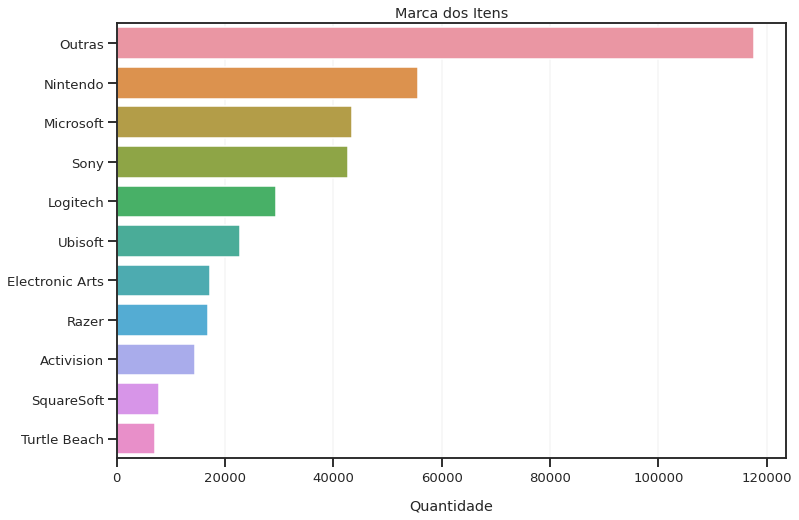

In [72]:
brands = df_cleaned['brand'].value_counts().reset_index()

plt.title('Marca dos Itens')
sns.barplot(x='brand', y='index', data=brands)
plt.xlabel('Quantidade')
plt.ylabel('')
plt.show()

# 5 - Modeling - Classificação dos valores nulos no campo verified

Vou rodar 3 modelos com a implementação padrão:

1.   Decision Tree
1.   Random Forest
1.   Gradient Boosting
1.   XGBoosting

Após avaliar suas métricas, vou escolher o com melhor desempenho e realizar um tunning utilizando o GridSearchCV do Scikit Learn.

Depois vou realizar a classificação dos campo verified nulos utilizando o modelo otimizado.




In [73]:
df_cleaned.shape

(374973, 16)

In [74]:
df_cleaned.head(2)

,reviewTime,reviewerID,reviewerName,asin,title,brand,main_category,plataform,specific_category,description,summary,feature,unixReviewTime,reviewText,verified,overall
0,2018-01-02,A16FEXIKAPT24U,Nicholas Sabin,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Game disc 1 was cracked,1 Player,1514851200,Game disc was cracked thats pretty lame,NaN,1
1,2018-01-02,A16FEXIKAPT24U,Nicholas Sabin,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Game disc 1 was cracked,1 Player,1514851200,Game disc was cracked thats pretty lame,NaN,1


**Selecionando as features**

In [75]:
# Função para a seleção das fetures
def feature_selection(df):
  # Excluindo do X colunas que não entrarão no modelo e setando o y com os valores de verified.
  X = df.drop(columns=['reviewTime', 'reviewerID', 'reviewerName', 'asin',
                       'title', 'description', 'summary', 'feature', 'reviewText', 'verified'])
  # Realizar o One Hot Encoding das variáveis categóricas
  X = pd.get_dummies(X)
  # Setando a variável verified como target
  y = df['verified']
  return X, y

In [76]:
# Separando os datasets
# Filtrando para a modelagem apenas os dados que tem o campo verified preenchido
# E deixando os que tem o campo nulo para a classificação
df_model = df_cleaned[~df_cleaned['verified'].isna()]
df_classification = df_cleaned[df_cleaned['verified'].isna()]

In [77]:
X , y = feature_selection(df_model)

In [78]:
print(X.shape)
print(y.shape)

(316006, 51)
(316006,)


**Listar para guardar os resultados dos modelos testados.**

In [79]:
scores_list = []
models_list = []

**Train Test Split**

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [81]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((252804, 51), (63202, 51), (252804,), (63202,))

### 5.1 Decision Tree

In [82]:
clf_DTC = DecisionTreeClassifier()
clf_DTC.fit(X_train, y_train)

DecisionTreeClassifier()

In [83]:
y_pred_DTC = clf_DTC.predict(X_test)

acuracia_DTC = accuracy_score(y_test, y_pred_DTC)
f1_score_DTC = f1_score(y_test, y_pred_DTC)
recall_DTC = recall_score(y_test, y_pred_DTC)
precision_DTC = precision_score(y_test, y_pred_DTC)

models_list.append('Decision Tree')
scores_list.append({'acuracia': acuracia_DTC, 'f1-score': f1_score_DTC, 'recall': recall_DTC, 'precision': precision_DTC})

print(f'Acurácia: {acuracia_DTC:.2%}')
print(f'F-1 Score: {f1_score_DTC:.2%}')
print(f'Recall: {recall_DTC:.2%}')
print(f'Precision: {precision_DTC:.2%}')

Acurácia: 82.26%
F-1 Score: 88.92%
Recall: 88.53%
Precision: 89.31%


### 5.2 Random Forest

In [84]:
clf_RFC = RandomForestClassifier()
clf_RFC.fit(X_train, y_train)

RandomForestClassifier()

In [85]:
y_pred_RFC = clf_RFC.predict(X_test)

acuracia_RF = accuracy_score(y_test, y_pred_RFC)
f1_score_RF = f1_score(y_test, y_pred_RFC)
recall_RF = recall_score(y_test, y_pred_RFC)
precision_RF = precision_score(y_test, y_pred_RFC)

models_list.append('RandomForest')
scores_list.append({'acuracia': acuracia_RF, 'f1-score': f1_score_RF, 'recall': recall_RF, 'precision': precision_RF})

print(f'Acurácia: {acuracia_RF:.2%}')
print(f'F-1 Score: {f1_score_RF:.2%}')
print(f'Recall: {recall_RF:.2%}')
print(f'Precision: {precision_RF:.2%}')

Acurácia: 83.87%
F-1 Score: 90.10%
Recall: 91.24%
Precision: 88.98%


### 5.3 Gradient Boosting

In [86]:
clf_Gb = GradientBoostingClassifier(n_estimators=250, subsample=1)
clf_Gb.fit(X_train, y_train.ravel())

GradientBoostingClassifier(n_estimators=250, subsample=1)

In [87]:
y_pred_Gb = clf_Gb.predict(X_test)

acuracia_Gb = accuracy_score(y_test, y_pred_Gb)
f1_score_Gb = f1_score(y_test, y_pred_Gb)
recall_Gb = recall_score(y_test, y_pred_Gb)
precision_Gb = precision_score(y_test, y_pred_Gb)

models_list.append('GradientBoosting')
scores_list.append({'acuracia': acuracia_Gb, 'f1-score': f1_score_Gb, 'recall': recall_Gb, 'precision': precision_Gb})

print(f'Acurácia: {acuracia_Gb:.2%}')
print(f'F-1 Score: {f1_score_Gb:.2%}')
print(f'Recall: {recall_Gb:.2%}')
print(f'Precision: {precision_Gb:.2%}')

Acurácia: 86.73%
F-1 Score: 92.19%
Recall: 97.39%
Precision: 87.52%


### 5.4 XGBoost

In [88]:
clf_XGb = XGBClassifier(n_estimators=200)
clf_XGb.fit(X_train, y_train.ravel())

XGBClassifier(n_estimators=200)

In [89]:
y_pred_XGb = clf_XGb.predict(X_test)

acuracia_XGb = accuracy_score(y_test, y_pred_XGb)
f1_score_XGb = f1_score(y_test, y_pred_XGb)
recall_XGb = recall_score(y_test, y_pred_XGb)
precision_XGb = precision_score(y_test, y_pred_XGb)

models_list.append('XGBoosting')
scores_list.append({'acuracia': acuracia_XGb, 'f1-score': f1_score_XGb, 'recall': recall_XGb, 'precision': precision_XGb})

print(f'Acurácia: {acuracia_XGb:.2%}')
print(f'F-1 Score: {f1_score_XGb:.2%}')
print(f'Recall: {recall_XGb:.2%}')
print(f'Precision: {precision_XGb:.2%}')

Acurácia: 86.62%
F-1 Score: 92.14%
Recall: 97.52%
Precision: 87.32%


### 5.5 Avaliação dos modelos

Todos os modelos tiveram uma performance boa.

Vou utilizar como critério o ***F1-Score*** que é uma média harmônica entre ***precision*** e ***recall***.

Sendo assim o modelo escolhido será o Gradient Boosting da biblioteca scikit-learn.

In [90]:
model_scores = pd.DataFrame(scores_list, index=models_list)

In [91]:
model_scores

,acuracia,f1-score,recall,precision
Decision Tree,0.823,0.889,0.885,0.893
RandomForest,0.839,0.901,0.912,0.890
GradientBoosting,0.867,0.922,0.974,0.875
XGBoosting,0.866,0.921,0.975,0.873


### 5.6 Otimização do modelo

In [ ]:
params = {
    'n_estimators':[100, 250],
    'learning_rate': [0.05, 0.1],
    'max_depth':[3, 5, 8],
    "subsample":[0.8, 1.0]
    }

In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), 
                          param_grid=params, scoring='f1', n_jobs=-1, verbose=5)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 8],
                         'n_estimators': [100, 250], 'subsample': [0.8, 1.0]},
             scoring='f1', verbose=5)

In [ ]:
clf.best_params_

{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}

In [94]:
# Best parameters
clf = GradientBoostingClassifier(learning_rate=0.05, max_depth=8, n_estimators=250, subsample=0.8)
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=8, n_estimators=250,
                           subsample=0.8)

In [95]:
y_pred = clf.predict(X_test)

acuracia_bestGb = accuracy_score(y_test, y_pred)
f1_score_bestGb  = f1_score(y_test, y_pred)
recall_bestGb  = recall_score(y_test, y_pred)
precision_bestGb  = precision_score(y_test, y_pred)

models_list.append('Tunned Gradient Boosting')
scores_list.append({'acuracia': acuracia_bestGb, 'f1-score': f1_score_bestGb, 'recall': recall_bestGb, 'precision': precision_bestGb})

In [96]:
model_scores = pd.DataFrame(scores_list, index=models_list)
model_scores

,acuracia,f1-score,recall,precision
Decision Tree,0.823,0.889,0.885,0.893
RandomForest,0.839,0.901,0.912,0.890
GradientBoosting,0.867,0.922,0.974,0.875
XGBoosting,0.866,0.921,0.975,0.873
Tunned Gradient Boosting,0.872,0.924,0.972,0.881


### 5.7 Classificando os verifieds nulos

In [97]:
X_classifier , y_nan = feature_selection(df_classification)

In [100]:
X_classifier

,unixReviewTime,overall,brand_Activision,brand_Electronic Arts,brand_Logitech,brand_Microsoft,brand_Nintendo,brand_Outras,brand_Razer,brand_Sony,brand_SquareSoft,brand_Turtle Beach,brand_Ubisoft,main_category_All Electronics,main_category_Amazon Home,main_category_Computers,main_category_Sports & Outdoors,main_category_Video Games,plataform_Accessories,plataform_Digital Games,plataform_Kids & Family,plataform_Nintendo 3DS & 2DS,plataform_Nintendo DS,plataform_PC,plataform_PlayStation 3,plataform_PlayStation 4,plataform_PlayStation Vita,plataform_Retro Gaming,plataform_Wii,plataform_Wii U,plataform_Xbox 360,plataform_Xbox One,specific_category_Accessories,specific_category_Consoles,specific_category_Currency & Subscription Cards,specific_category_Digital Games & DLC,specific_category_Game Boy Advance,specific_category_GameCube,specific_category_Games,specific_category_Interactive Gaming Figures,specific_category_Nintendo 3DS,specific_category_Outros,specific_category_PC,specific_category_PlayStation,specific_category_PlayStation 2,specific_category_PlayStation 3,specific_category_PlayStation 4,specific_category_Wii,specific_category_Wii U,specific_category_Xbox,specific_category_Xbox 360
0,1514851200,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1514851200,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
24,1503878400,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
25,1503878400,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
26,1502150400,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450388,1534032000,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
450406,1538352000,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
450410,1538179200,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
450414,1538438400,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
# Todos os valores são nulos, conforme esperado
y_nan

0        NaN
1        NaN
24       NaN
25       NaN
26       NaN
          ..
450388   NaN
450406   NaN
450410   NaN
450414   NaN
450422   NaN
Name: verified, Length: 58967, dtype: float64

In [101]:
# Vou substituir a variável verified com os valores preditos pelo modelo.
df_classification['verified'] = clf.predict(X_classifier)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
# Agora todos os valores que antes eram nulos estão classificados.
df_classification['verified'].value_counts()

1.0    51511
0.0     7456
Name: verified, dtype: int64

In [105]:
# Unir os dados novamente para ter o dataset final que seguirá para o sistema de recomendação
df_reviews_final = pd.concat([df_model, df_classification])
print(df_reviews_final.shape)
df_reviews_final.head(3)

(374973, 16)


,reviewTime,reviewerID,reviewerName,asin,title,brand,main_category,plataform,specific_category,description,summary,feature,unixReviewTime,reviewText,verified,overall
2,2018-01-02,A3ISBEPYLY8IMO,Jimmy,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Received this in perfect condition. Great rese...,1 Player,1514851200,Received this in perfect condition. Great rese...,1.0,5
3,2018-01-02,A3ISBEPYLY8IMO,Jimmy,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,Received this in perfect condition. Great rese...,1 Player,1514851200,Received this in perfect condition. Great rese...,1.0,5
4,2017-12-21,A1RIUB1PZWLOVZ,Amazon Customer,B00000JRSB,Final Fantasy VII,SquareSoft,Video Games,Retro Gaming,PlayStation,Long recognized as role-playing games par exce...,I am very pleased with this purchase,1 Player,1513814400,I had a hard time finding this game locally or...,1.0,5


Rever a distribuição das avaliações verificadas agora que as nulas foram classificadas

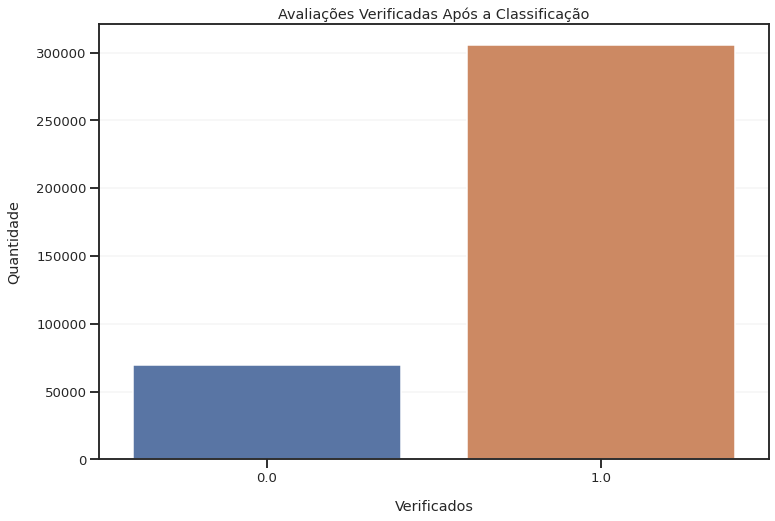

In [107]:
verifieds_final = df_reviews_final['verified'].value_counts().reset_index()

plt.title('Avaliações Verificadas Após a Classificação')
sns.barplot(x='index', y='verified', data=verifieds_final)
plt.xlabel('Verificados')
plt.ylabel('Quantidade')
plt.show()

# 6 - Sistema de Recomendação

### 6.1 - Selecionando a matriz de usuários, itens e as respectivas notas

In [135]:
# Filtrando as avaliações verificadas
games_reviews = df_reviews_final.loc[df_reviews_final.verified == 1, ['reviewerID', 'asin', 'overall']]

games_reviews.head(2)

,reviewerID,asin,overall
2,A3ISBEPYLY8IMO,B00000JRSB,5
3,A3ISBEPYLY8IMO,B00000JRSB,5


### 6.2 - Definindo as Funções para a manipulação do dataframe e criação da matriz de similaridade utilizando o **cosine_similarity** do sklearn.

In [115]:
def start_pipeline(dataf):
  return dataf.copy()


def get_itens_counts(dataf):
  return dataf.groupby(by='asin', as_index=False) \
    .agg({'reviewerID': pd.Series.nunique}) \
    .rename(columns={'reviewerID': 'reviewerID_count'}) \
    .set_index('asin') \
    .sort_values('reviewerID_count', ascending = False)


def get_n_top_values(dataf, n):
  return dataf.head(n) \
    .index \
    .tolist()


def format_sample(dataf):
  return pd.DataFrame({
      "user": dataf["reviewerID"],
      "iten": dataf["asin"],
      "action": dataf["overall"]
  })


def get_top_itens_ids(dataf, sample_size=1000):
  return dataf \
    .pipe(start_pipeline) \
    .pipe(get_itens_counts) \
    .pipe(get_n_top_values, sample_size)


def get_item_based_similarity_matrix(data):
  top_itens_ids = get_top_itens_ids(data)
  itens_sampled_relationship_data = data[data["asin"].isin(top_itens_ids)] \
    .pipe(format_sample) \
    .pivot_table(index="user", columns="iten", values="action").fillna(0)
  return cosine_similarity(itens_sampled_relationship_data.T), itens_sampled_relationship_data.T.index


### 6.3 - Criando a Classe com os métodos responsáveis por devolver os itens recomendados

In [116]:
class ItemBasedRecommender:

  def __init__(self, dataf):
    self.dataf = dataf

  def setup(self):
    data = self.dataf
    sim_matrix, available_items_index = get_item_based_similarity_matrix(data)
    self.available_items_index = available_items_index
    self.sim_matrix = sim_matrix

  def get_random_item_index(self):
    item_id = self.available_items_index[random.randint(0, self.sim_matrix.shape[0])]
    return item_id

  def get_n_closest(self, item_id, n=10):
    if item_id not in self.available_items_index:
      raise ValueError('Item is not available on data.')
    item_index = self.available_items_index.tolist().index(item_id)
    closest_n_iten = np.argsort(-self.sim_matrix[item_index])[1:n]
    n_closest = []
    for item_data in zip(self.available_items_index[closest_n_iten], self.sim_matrix[item_index][closest_n_iten]):
      n_closest.append(item_data)
    return tuple(n_closest)

### 6.4 - Exemplo de utilização do sistema de recomendação

In [136]:
item_recommender = ItemBasedRecommender(games_reviews)

item_recommender.setup()

In [137]:
# Buscando um item aleatório dentro da matriz
some_item_id = item_recommender.get_random_item_index()

# Fazendo a recomendação
item_recommender.get_n_closest(some_item_id)

(('B00BXONG7G', 0.02290532653514634),
 ('B00009OY9U', 0.007596024356431554),
 ('B00140P9BA', 0.0057697202299344785),
 ('B00178630A', 0.005219377140819536),
 ('B001FY7LBQ', 0.004323361601946442),
 ('B000ZKA0J6', 0.004294152021348337),
 ('B00Z0UWWYC', 0.004096632603791174),
 ('B00BFOEY4I', 0.004014173261898223),
 ('B000FQ2D5E', 0.0038740170144561147))

In [138]:
# Teste com item inexistente na base, retorna um Value Error
item_recommender.get_n_closest('ITEM_NAO_EXISTE')

ValueError: ignored

In [139]:
# Pegando uma recomendação simples dos 10 mais avaliados (não leva em consideração a nota)

top_10_mais_avaliados = get_itens_counts(games_reviews)[:10].index.tolist()

In [140]:
# Tratamento da exceção ValueError, apresentando os top 10 itens mais avaliados

try:
  item_recommender.get_n_closest('ITEM_NAO_EXISTE')
except ValueError:
  print(top_10_mais_avaliados)

['B004RMK57U', 'B00E4MQODC', 'B00DBDPOZ4', 'B000HZFCT2', 'B00CMN0Z0S', 'B00BFOEY4I', 'B00GU8W5AE', 'B00BGA9X9W', 'B00AAS888S', 'B012DFI02O']
